# 3_SPHEREx_Sensitivity
# Understand how SPHEREx sensitivity limits are determined

## Authors
- Yujin Yang, Woong-Seob Jeong (KASI SPHEREx Team)
- **Sky background slides from Woong-Seob**

## Goal
- Understand how T(exp) is determined from the survey requirements
- Understand how SPHEREx detection limits are determined

<div class="alert alert-block alert-danger">
    <span style='font-size:18px'>
    The numbers in this notebook is for approximation only to illustrate SPHEREx sensitivity.
    </span>    
</div>
<div class="alert alert-block alert-danger">
    <span style='font-size:18px'>
    Always consult offical SPHEREx publications.
    </span>    
</div>

## <span style='color:DarkSlateBlue'> Setting for this notebook </span>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"   # last or last_expr

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from numpy import sqrt, exp, log10, pi
from astropy import units as u
from astropy import constants as const
from astropy.table import Table, QTable, join, vstack

mpl.rcParams["axes.titlesize"] = 13
mpl.rcParams["axes.labelsize"] = 15

In [3]:
# Constants
c_ums = 3e14               # c in um/s
c = 3e8                    # m/s
h = 6.626e-34              # Planck constant   [J/Hz]
k = 1.38e-23               # Boltzman constant [J/K]
rad2arcsec = (180/pi*3600) # 206265 arcsec
arcsec2rad = 1/rad2arcsec

## <span style='color:DarkSlateBlue'> 1. SPHEREx Parameters - telescope, detectors, LVFs, efficiencies </span>

### Band Information

In [4]:
# SPHEREx Band ID (1,2,3,4,5,6)
iband = 6

In [5]:
SPHEREx_lambda_min = np.array([0.75, 1.11, 1.64, 2.42, 3.82, 4.42])  # starting wavelength
SPHEREx_R = np.array([41, 41, 41, 35, 110, 130])                     # Resolving power
SPHEREx_eff_LVF = np.array([0.97, 0.97, 0.88, 0.86, 0.78, 0.72])     # LVF efficiency

### Telescope

In [6]:
D = 20.             # effetive diameter [cm]
F = 3.0             # F-number
EFL = D*F           # effective focal length [cm]
WFE = 0.25          # wave front error [um]
rms_pointing = 1.0  # pointing accuray [arcsec]

### H2RG Detectors

In [7]:
array = 'HgCdTe'   # detector array type
Npix = 2048        # [pixels], detector format
dQ_CDS = 12.5      # [e]
I_dark = 0.01      # [e/s], dark current
pixel_size = 18.0  # [um], "pitch"
Tsamp = 1.5        # sampling time of IR detectors [sec]

### Linear Variable Filters (LVFs)

In [8]:
R = 41             # Resolving power
R = SPHEREx_R[iband-1]
Nchan = 16         # number of channels per band (or steps)

lambda_min = 0.75  # starting wavelength
lambda_min = SPHEREx_lambda_min[iband-1]  # starting wavelength
lambda_max = lambda_min * ((2*R+1)/(2*R-1))**Nchan
lambda_mid = (lambda_min + lambda_max)/2

print(f'lambda_min = {lambda_min:8.3f}')
print(f'lambda_mid = {lambda_mid:8.3f}')
print(f'lambda_max = {lambda_max:8.3f}')

lambda_min =    4.420
lambda_mid =    4.709
lambda_max =    4.999


### Efficiencies

In [9]:
eff_mirrors_Au = (0.965)**3  # Gold coating, 3 mirrors
eff_dichroic = 0.98          # splitter
eff_LVF = 0.97               # LVF peak transmission
eff_LVF = SPHEREx_eff_LVF[iband-1]
eff_fpa = 0.75               # Detector Quantum Efficiency (QE)

T_scope = 80.    # temperature of the telescope [K]
T_FPA   = 50.    # temperature of the focal plane array (FPA) [K]

eff_opt   = eff_mirrors_Au * eff_dichroic * eff_LVF
eff_total = eff_opt * eff_fpa

eff_opt, eff_total

(0.6340748273999999, 0.4755561205499999)

## <span style='color:DarkSlateBlue'> 2. (Derived) SPHEREx Properties  </span>

### LVF Channels and Detectors
 - plate scale [arcsec/mm] = $\frac{206265}{f [mm]}$
     - f = effective focal length (EFL)
 - convert to pixel scale
     - pixscale = plate scale * detector pixel size

In [10]:
# Pixel scale, FOV in spatial direction
theta_pixel = rad2arcsec * pixel_size*0.0001/EFL  # [arcsec], pixel scale
theta_x = theta_pixel * Npix / 3600               # [deg], FOV in spatial direction (x)
theta_x, theta_pixel

(3.520252693283778, 6.187944187412891)

In [11]:
# Length of one channel on the sky
# Spectral response same for this angle on the sky
# "spec" == channel
theta_spec = Npix / Nchan * theta_pixel / 60  # [arcmin]

# Angular area for which one exposure (pointing) can get spectrum for a given channel
# 하나의 채널이 검출기에서 차지하는 영역의 각 넓이
# 한번에 관측할 수 있는 하늘의 영역
FOV_spec = (theta_spec/60) * theta_x          # [deg^2]
FOV_spec

# Length of spectrum per channel
Npix_per_channel = (Npix) / (Nchan)

0.7745111890357308

In [12]:
theta_spec

13.200947599814167

In [13]:
# diffraction-limited PSF size = 1.22 (lambda/D)
theta_diffraction = 1.22 * (lambda_mid*1e-4) / D * rad2arcsec

# Area of a pixel in steradian
pixel_sr = (theta_pixel*arcsec2rad)**2

# (Area) x (solid angle) per pixel [m^2 sr]
AOmega = pi * (D/2/100)**2 * pixel_sr

In [14]:
print(f"FOV_spec          = {FOV_spec:8.3f} deg^2")
print(f"theta_spec        = {theta_spec:8.3f} arcmin")
print(f"Npix_per_channel  = {Npix_per_channel:8.3f} pixels")
print(f"theta_x           = {theta_x:8.3f} deg")
print(f"theta_pixel       = {theta_pixel:8.3f} arcsec")
print(f"fwhm_diffraction  = {theta_diffraction:8.3f} arcsec")
print(f"pixel_sr          = {pixel_sr:8.2e} sr")
print(f"AOmega            = {AOmega:8.2e} m^2 sr")

FOV_spec          =    0.775 deg^2
theta_spec        =   13.201 arcmin
Npix_per_channel  =  128.000 pixels
theta_x           =    3.520 deg
theta_pixel       =    6.188 arcsec
fwhm_diffraction  =    5.926 arcsec
pixel_sr          = 9.00e-10 sr
AOmega            = 2.83e-11 m^2 sr


### PSFs due to the optics and the spacecraft
- diffraction
$$ \mathbf{FWHM} = 1.22 \dfrac{\lambda}{D} $$
- imperfections in the optics (wave front error)
$$ \mathbf{Strehl~ratio} \simeq \exp{\left[-\left(2\pi\frac{\sigma}{\lambda}\right)^2\right]} $$
$$ \mathbf{Strehl~ratio} \sim \left(\frac{\mathbf{FWHM_{diffration}}}{\mathbf{FWHM}}\right)^2 $$
- jitter in the spacecraft (pointing stability)

<div class="alert alert-block alert-danger">
    <span style='font-size:18px'>
        This FWHM approximation is very crude. Use it with a caution outside this notebook!
    </span>    
</div>

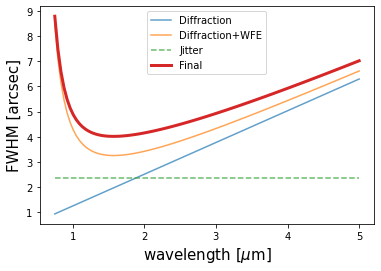

In [15]:
# wavlength vector in um
wl = np.linspace(0.75, 5, 100)   

# Diffraction-limited PSF width
fwhm_diffraction = 1.22*wl/(D*1e4) * rad2arcsec

# PSF width due to the wave front error
# Note that this equation is over-approximation at shorther wavelength!
fwhm_wfe = fwhm_diffraction * sqrt(exp((2*pi*WFE/wl)**2))

# Different approximation can be used!
# fwhm_wfe = fwhm_diffraction * sqrt(1 + (2*pi*WFE/wl)**2)
# fwhm_wfe = fwhm_diffraction *     (1 + (2*pi*WFE/wl)**2)

# PSF due to spacecraft pointing stability
fwhm_jitter = rms_pointing * 2.35 * np.ones_like(wl)

# Final PSF width = quadrature sum of the two
fwhm_final = sqrt(fwhm_wfe**2 + fwhm_jitter**2)

_ = plt.plot(wl, fwhm_diffraction, label='Diffraction', alpha=0.7)
_ = plt.plot(wl, fwhm_wfe, label='Diffraction+WFE', alpha=0.7)
_ = plt.plot(wl, fwhm_jitter, label='Jitter', alpha=0.7, linestyle='--')
_ = plt.plot(wl, fwhm_final, label='Final', linewidth=3)
_ = plt.legend()
_ = plt.xlabel('wavelength [$\mu$m]')
_ = plt.ylabel('FWHM [arcsec]')

In [16]:
wl  = lambda_mid  # um

fwhm_diffraction = 1.22*wl/(D*1e4) * rad2arcsec
fwhm_wfe = fwhm_diffraction * sqrt(exp((2*pi*WFE/wl)**2))
fwhm_jitter = rms_pointing * 2.35 * np.ones_like(wl)

FWHM0 = sqrt(fwhm_wfe**2 + fwhm_jitter**2)
wl, FWHM0

(4.7094483449386075, 6.690722996327264)

In [17]:
# How many pixels does a point source occupy?
# Effective number of pixels for a Gaussian PSF with FWHM0
Npix0 = pi*(FWHM0/theta_pixel)**2
Npix0

3.672850040522937

## <span style='color:DarkSlateBlue'> 3. Survey Plan & Design </span>

### Mission cycle

In [18]:
T_mission = 2  # year
resolutionElement_per_survey = 1  # Nyquist = 0.5
Sh_Redun  = 2 / resolutionElement_per_survey # per year [2=visit twice]

# Survey inefficiency margin
# How much will we lose the observing time due to unexpected circumstances?
Sh_Inefficiency = 1.2    # 1.0 = perpect, 1.2 = 20% is wasted

# All-sky steps per year = (4pi / FOV_spec)
Area_allsky = 4*pi*(180/pi)**2  # [deg^2] = 4pi steradian
Nsteps_per_year = (Area_allsky/FOV_spec) * Sh_Redun * Sh_Inefficiency

# all-sky survey를 위해 1년 동안 필요한 pointing/step 개수
Nsteps_per_year

127831.73232380344

### Orbit
- Unusable times during an orbit
    - Downlink
    - SAA (South Atlantic Anomaly): area where Earth's inner Van Allen radiation belt comes closest to Earth's surface (an altitude of 200 km)
    - Large slew
    - Small slew

In [19]:
Tmin_orbit = 98.6                 # [min], time per orbit 
TM_downlink = 60.                 # [sec/orbit] Downlink 시간
SAA_time = 415                    # [sec/orbit] South Atlantic Anomaly 시간

N_orbits_per_year = 365.25*24*60/Tmin_orbit
N_orbits_per_year

5334.279918864097

### Orbit split to all-sky & deep fields

In [20]:
# Large steps (여러 개의 small step들로 이루어진)
lg_steps_per_orbit = 8                          # [/orbit] 한 바퀴당 all-sky에 쓸 large step 개수
lg_step_time = Tmin_orbit*60/lg_steps_per_orbit # [sec] large step당 시간

lg_SS_time = 90           # [sec]      large slew 당 필요한 시간 (spacecraft 성능)
sm_SS_time =  8           # [sec]      small slew 당 필요한 시간 (spacecraft 성능)

# Fraction of time to be used fro all-sky
# 전체 시간 중 얼마나 전천탐사에 시간을 쓸 것인가?
frac_allsky = 0.8   

# small steps per one large step to cover all-sky
# 전천을 완전히 커버하기 위해, 큰 step 당 필요한 small step 개수
sm_steps = Nsteps_per_year / N_orbits_per_year / lg_steps_per_orbit  # [/lg step]
sm_steps

2.9955245662994856

### All-sky exposure time per channel (= step in this notebook)

In [21]:
T_usable_per_orbit = ( Tmin_orbit*60                                   # Total orbit
                     - lg_steps_per_orbit * lg_SS_time                 # 큰 스텝 사이의 이동시간
                     - lg_steps_per_orbit * (sm_steps-1) * sm_SS_time  # 작은 스텝 사이의 이동시간 (all-sky)
                     - TM_downlink                                     # downlink
                     - SAA_time )                                      # SAA

Tint = T_usable_per_orbit / (lg_steps_per_orbit * sm_steps)
Tint *= frac_allsky


Tmin_orbit*60       # 한 바퀴 시간 [sec]
T_usable_per_orbit  # 한 바퀴당 실제 사용가능한 시간 [sec]
TM_downlink         # Downlink 시간
SAA_time            # South Atlantic Anomaly 시간
Tint                # total integration time

5916.0

4593.286427756833

60.0

415

153.33829938945016

In [22]:
print(f"T_mission        = {T_mission:10d} yr")
print(f"Sh_Redun         = {Sh_Redun:10.2f} survey/yr")
print(f"Sh_Inefficiency  = {Sh_Inefficiency:10.2f}")
print(f"T_orbit          = {Tmin_orbit:10.2f} min")
print(f"T_downlink       = {TM_downlink:10.0f} sec")
print(f"SAA_time         = {SAA_time:10.0f} sec")
print(f"N_orbit_per_year = {N_orbits_per_year:10.2f} orbits")
print("")
print(f"lg_SS_time       = {lg_SS_time:10.0f} sec")
print(f"sm_SS_time       = {sm_SS_time:10.0f} sec")
print(f"lg_steps         = {lg_steps_per_orbit:10.1f}")
print("")
print(f"All-sky steps    = {Nsteps_per_year:10.2f} step/yr")
print(f"Tint             = {Tint:10.2f} sec")

T_mission        =          2 yr
Sh_Redun         =       2.00 survey/yr
Sh_Inefficiency  =       1.20
T_orbit          =      98.60 min
T_downlink       =         60 sec
SAA_time         =        415 sec
N_orbit_per_year =    5334.28 orbits

lg_SS_time       =         90 sec
sm_SS_time       =          8 sec
lg_steps         =        8.0

All-sky steps    =  127831.73 step/yr
Tint             =     153.34 sec


### These are only numbers that matter in the following

In [23]:
# Tint ~ 150

## <span style='color:DarkSlateBlue'> 4. Noise Sources </span>

### Readout noise per integration
- IR detector sampling scheme

In [24]:
dQ_RN_sh = dQ_CDS*np.sqrt(6*Tsamp/Tint) # [e]

### Sky background: Zodiacal Light (황도광)
- **ZL is time-varying component**, but here we adopet an average
- $\nu I_\nu$ from ZL
- $\nu I_\nu$ [nW/m2/sr]
- $I_\nu$ [nW/m2/sr/$\mu$m]


In [25]:
def nuInu_ZL(lambda_um, f_ZL=1.7):
    # very rough approximation for ZL
    # nuInu(sky): fit for zodiacal light [nW/m2/sr]
    # f_ZL = a fudge factor for margin
    A_scat = 3800
    T_scat = 5500
    b_scat = 0.4
    A_therm = 5000
    T_therm = 270
    nuInu = f_ZL * ( A_scat*(lambda_um**b_scat)*((lambda_um)**(-4))/(exp(h*c_ums/(k*T_scat *lambda_um))-1)
                    +A_therm*1000000           *((lambda_um)**(-4))/(exp(h*c_ums/(k*T_therm*lambda_um))-1) )
    return nuInu

Text(0.5, 0, 'wavelength [$\\mu$m]')

Text(0, 0.5, '$\\nu I_\\nu$ [nW/m2/sr]')

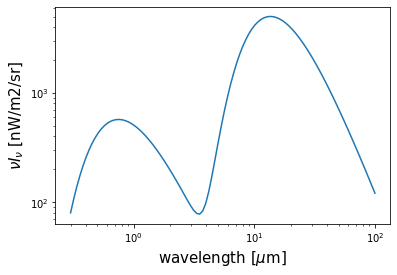

In [26]:
wl = np.logspace(np.log10(0.3), np.log10(100), 100)   
plt.plot(wl, nuInu_ZL(wl))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('wavelength [$\mu$m]')
plt.ylabel(r'$\nu I_\nu$ [nW/m2/sr]')

In [27]:
# Sky background rate
# nuInu_sky = surface brightness  [nW/m2/sr]
# I_photo = photo-current rate    [e/s]
# Q_photo = total counts          [e]

nuInu_sky = nuInu_ZL(lambda_mid)   # [nW/m2/sr]
I_photo = 1e-9 * nuInu_sky*AOmega*eff_opt*eff_fpa/(R*h*c_ums/lambda_mid)  # [e/s]

# Noise in count per obs [e]. 
# f_margin = 1.2 due to background estimation
Q_photo = (I_photo+I_dark)*Tint
dQ_photo = np.sqrt( 1.2*(I_photo+I_dark)*Tint )

# Noise in count rate [e/s]
dI_photo = np.sqrt(dQ_photo**2 + dQ_RN_sh**2)/Tint

# Noise in nuInu [nW/M2/sr]
dnuInu_sh = (dI_photo/I_photo)*nuInu_sky

In [29]:
print(f"wavelength_mid = {lambda_mid:12.3f} um")
print(f"nuInu_sky      = {nuInu_sky:12.5f} nW/m2/sr")
print(f"I_photo        = {I_photo:12.5g} e-/s")
print(f"dI_photo       = {dI_photo:12.5g} e-/s")
print(f"Q_photo        = {Q_photo:12.5g} e-")
print(f"dQ_photo       = {dQ_photo:12.5g} e-")
print(f"dnuInu_sky     = {dnuInu_sh:12.5g} nW/m2/sr")

wavelength_mid =        4.709 um
nuInu_sky      =    240.67776 nW/m2/sr
I_photo        =      0.58977 e-/s
dI_photo       =       0.0713 e-/s
Q_photo        =       91.968 e-
dQ_photo       =       10.505 e-
dnuInu_sky     =       29.097 nW/m2/sr


### Thermal background from telescope & FPA
- $\nu I_\nu$ from the instrument [nW/m2/sr]
- Blackbody radiation 
 $$ \nu I_\nu = 
    \dfrac{2h}{c^2}  \left(\dfrac{c}{\lambda}\right)^4 
    \dfrac{1}{\exp{\left(\dfrac{h c}{k T \lambda}\right)} - 1} $$

In [30]:
# Surface brightness in (nu Inu) [nW/m2/sr]
# T_scope = 120
# T_FPA   = 120

# Telescope
hc_kTlambda = h * (c_ums/lambda_max) / (k*T_scope)
nuInu_scope = (2*h/c**2) * (c_ums / lambda_max)**4 / (np.exp(hc_kTlambda) - 1) / 1e-9

# FPA
hc_kTlambda = h * (c_ums/lambda_max) / (k*T_FPA)
nuInu_FPA   = (2*h/c**2) * (c_ums / lambda_max)**4 / (np.exp(hc_kTlambda) - 1) / 1e-9

In [32]:
# Iphoto

# Count rates [e/s]
I_scope = 1e-9 * nuInu_scope * pi*(pixel_size*1e-6)**2/R*eff_LVF*eff_fpa/(h*c_ums/lambda_max)
I_FPA   = 1e-9 * nuInu_FPA   * pi*(pixel_size*1e-6)**2          *eff_fpa/(h*c_ums/lambda_max)

In [33]:
print(f"wavelength_max = {lambda_max:12.3f} um")
print(f"nuInu(scope)   = {nuInu_scope:12.3e} nW/m2/sr")
print(f"nuInu(FPA)     = {nuInu_FPA:12.3e} nW/m2/sr")
print(f"I(scope)       = {I_scope:12.3e} e-/s")
print(f"I(FPA)         = {I_FPA:12.3e} e-/s")

wavelength_max =        4.999 um
nuInu(scope)   =    4.348e-02 nW/m2/sr
nuInu(FPA)     =    1.789e-11 nW/m2/sr
I(scope)       =    4.623e-03 e-/s
I(FPA)         =    3.434e-10 e-/s


## <span style='color:DarkSlateBlue'> 5. Sensitivity Estimates </span>

In [34]:
i_steps = [1]

# For all channels in this band
i_steps = np.arange(16,dtype=float)

lambda_i = lambda_min * (((2*R+1)/(2*R-1))**i_steps)
lambda_i

# Only for one wavelength
# lambda_i = np.array([lambda_mid])

# Sky
nuInu_sky = nuInu_ZL(lambda_i)
I_photo = 1e-9 * nuInu_sky*AOmega*eff_opt*eff_fpa/(R*h*c_ums/lambda_i)

# Instrument
I_photo = I_photo + I_scope + I_FPA

array([4.42      , 4.45413127, 4.48852611, 4.52318654, 4.55811462,
       4.59331242, 4.62878202, 4.66452551, 4.70054501, 4.73684265,
       4.77342059, 4.81028098, 4.84742601, 4.88485787, 4.92257878,
       4.96059097])

### Extended sources: SB limit

In [37]:
# SB noise per pixel: dnuInu [nW/m2/sr] (1sigma)
dQ_photo = sqrt( 1.2*(I_photo+I_dark)*Tint )
dI_photo = sqrt(dQ_photo**2 + dQ_RN_sh**2) / Tint
dnuInu_obs = (dI_photo/I_photo)*(nuInu_sky + nuInu_scope + nuInu_FPA)

# Final noise is for the entire mission
# - Sh_Redun = 2  # obs per year
# - T_mission = 2 # year
dnuInu_sh = dnuInu_obs / sqrt(Sh_Redun) / sqrt(T_mission)
dnuInu_sh

array([12.68081492, 12.87419644, 13.0750879 , 13.28332659, 13.49874207,
       13.72115708, 13.95038828, 14.18624702, 14.42854007, 14.67707029,
       14.93163716, 15.19203743, 15.45806552, 15.72951404, 16.00617418,
       16.28783603])

### Point sources: flux limit

In [39]:
# Flux for point sources: dFnu [uJy] (1sigma)

# FWHM of PSF
wl = lambda_i

FWHM_diffraction = 1.22*wl/(D*1e4) * rad2arcsec
FWHM_wfe = FWHM_diffraction * sqrt(exp((2*pi*WFE/wl)**2))
FWHM_jitter = rms_pointing * 2.35 * np.ones_like(wl)
FWHM = sqrt(FWHM_wfe**2 + FWHM_jitter**2)

# N(pixels) for a point-source
Npix_ptsrc = pi*(FWHM/theta_pixel)**2

# Conversion to flux density & AB magnitude
# CHECK!
dFnu_sh = sqrt(Npix_ptsrc) * 1e26 * 1e6 * pixel_sr * (dnuInu_sh*1e-9) * (lambda_i/c_ums)
mag5sig_sh = -2.5*log10(5*dFnu_sh*1e-6/3631)

In [75]:
dnuInu_sh

array([12.68081492, 12.87419644, 13.0750879 , 13.28332659, 13.49874207,
       13.72115708, 13.95038828, 14.18624702, 14.42854007, 14.67707029,
       14.93163716, 15.19203743, 15.45806552, 15.72951404, 16.00617418,
       16.28783603])

In [41]:
if len(lambda_i) == 1:
    print("lambda_i      = ", lambda_i)
    print("nuInu_sky     = ", nuInu_sky)
    print("I_photo       = ", I_photo)
    print("FWHM          = ", FWHM)
    print("Npix(ptsrc)   = ", Npix_ptsrc)
    print()
    print("dnuInu_sh     = ", dnuInu_sh)
    print("dFnu_sh       = ", dFnu_sh)
    print("mag5sig_sh    = ", mag5sig_sh)

In [42]:
# Create Astropy table 
SB  = u.nW/(u.m)**2/u.sr
cnt_rate = u.electron / u.s

band = np.zeros_like(lambda_i, dtype='int16') + iband

T_sens = (
    QTable( [band, lambda_i, nuInu_sky, I_photo, dnuInu_sh, dFnu_sh, mag5sig_sh], 
             names=('band', 'wavelength', 'nuInu_sky', 'I_photo_sky', 'dnuInu_sh', 'dFnu_sh', 'mag5sig_sh'),
             units=(None, u.um, SB, cnt_rate, SB, u.uJy, u.mag) )
)

# Tweak the print formatting
for key in T_sens.colnames:
    T_sens[key].info.format = '.4g'
    
T_sens

band,wavelength,nuInu_sky,I_photo_sky,dnuInu_sh,dFnu_sh,mag5sig_sh
,um,nW / (m2 sr),electron / s,nW / (m2 sr),uJy,mag
int16,float64,float64,float64,float64,float64,float64
6,4.42,165.5,0.3853,12.68,30.69,18.43
6,4.454,173,0.4055,12.87,31.59,18.4
6,4.489,180.9,0.427,13.08,32.52,18.37
6,4.523,189.2,0.4499,13.28,33.49,18.34
6,4.558,198,0.4742,13.5,34.49,18.31
6,4.593,207.2,0.4999,13.72,35.54,18.28
...,...,...,...,...,...,...
6,4.773,261,0.653,14.93,41.41,18.11


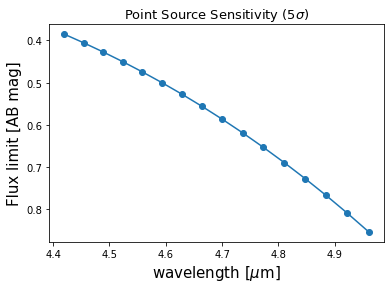

In [43]:
_ = plt.plot(T_sens['wavelength'], T_sens['I_photo_sky'], 'o-')
_ = plt.xlabel('wavelength [$\mu$m]')
_ = plt.ylabel('Flux limit [AB mag]')
_ = plt.title('Point Source Sensitivity (5$\sigma$)')
_ = plt.gca().invert_yaxis()

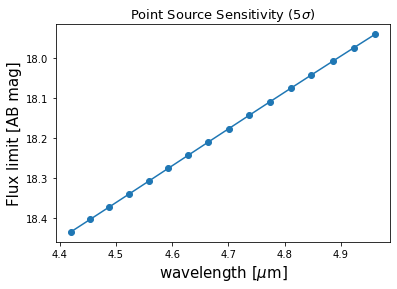

In [44]:
_ = plt.plot(T_sens['wavelength'], T_sens['mag5sig_sh'], 'o-')
_ = plt.xlabel('wavelength [$\mu$m]')
_ = plt.ylabel('Flux limit [AB mag]')
_ = plt.title('Point Source Sensitivity (5$\sigma$)')
_ = plt.gca().invert_yaxis()

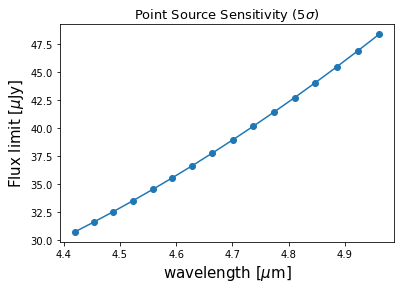

In [45]:
_ = plt.plot(T_sens['wavelength'], T_sens['dFnu_sh'], 'o-')
_ = plt.xlabel('wavelength [$\mu$m]')
_ = plt.ylabel('Flux limit [$\mu$Jy]')
_ = plt.title('Point Source Sensitivity (5$\sigma$)')

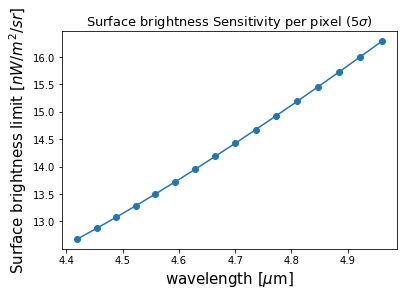

In [46]:
_ = plt.plot(T_sens['wavelength'], T_sens['dnuInu_sh'], 'o-')
_ = plt.xlabel('wavelength [$\mu$m]')
_ = plt.ylabel('Surface brightness limit [$nW/m^2/sr$]')
_ = plt.title('Surface brightness Sensitivity per pixel (5$\sigma$)')

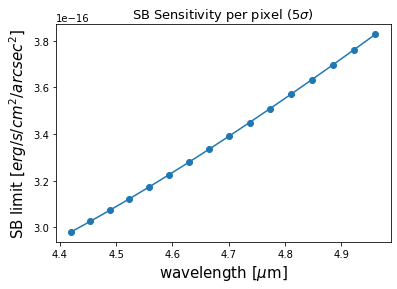

In [47]:
# In terms of CGS unit
# nW/m2/sr = 2.35e-17 erg/s/cm2/arcsec2
SB_cgs = T_sens['dnuInu_sh'] * 1e-9 * 1e7 / 1e4 / rad2arcsec**2

_ = plt.plot(T_sens['wavelength'], SB_cgs, 'o-')
_ = plt.xlabel('wavelength [$\mu$m]')


_ = plt.ylabel('SB limit [$erg/s/cm^2/arcsec^2$]')
_ = plt.title('SB Sensitivity per pixel (5$\sigma$)')

In [48]:
T_sens['wavelength']
T_sens['mag5sig_sh']

<Quantity [4.42      , 4.45413127, 4.48852611, 4.52318654, 4.55811462,
           4.59331242, 4.62878202, 4.66452551, 4.70054501, 4.73684265,
           4.77342059, 4.81028098, 4.84742601, 4.88485787, 4.92257878,
           4.96059097] um>

<Quantity [18.43499467, 18.40389284, 18.37238691, 18.34051158, 18.30830091,
           18.27578822, 18.24300593, 18.20998542, 18.17675698, 18.14334969,
           18.1097914 , 18.07610868, 18.0423268 , 18.00846971, 17.97456007,
           17.94061926] mag>

In [52]:
wl = [0.75, 0.76851852, 0.78749428, 0.80693859, 0.826863, 0.84727937, 0.86819985, 0.88963688, 0.91160322, 0.93411194, 0.95717644, 0.98081042, 1.005028, 1.0298435, 1.0552717, 1.0813278,1.11, 1.1374074, 1.1654915, 1.1942691, 1.2237572, 1.2539735, 1.2849358, 1.3166626, 1.3491728, 1.3824857, 1.4166211, 1.4515994, 1.4874414, 1.5241683, 1.5618021, 1.6003651, 1.64, 1.6804938, 1.7219875, 1.7645057, 1.8080738, 1.8527176, 1.8984637, 1.9453393, 1.9933724, 2.0425914, 2.0930258, 2.1447055, 2.1976611, 2.2519244, 2.3075275, 2.3645034, 2.42, 2.4901449, 2.562323, 2.6365933, 2.7130163, 2.7916544, 2.8725719, 2.9558349, 3.0415113, 3.129671, 3.2203861, 3.3137306, 3.4097808, 3.508615, 3.610314, 3.7149608,3.82, 3.8548858, 3.8900903, 3.9256162, 3.9614666, 3.9976444, 4.0341525, 4.0709941, 4.1081721, 4.1456897, 4.1835499, 4.2217558, 4.2603107, 4.2992176, 4.3384799, 4.3781007,  4.42, 4.4541313, 4.4885261, 4.5231865, 4.5581146, 4.5933124, 4.628782, 4.6645255, 4.700545, 4.7368427, 4.7734206, 4.810281, 4.847426, 4.8848579, 4.9225788, 4.960591]

In [53]:
mag5 = [19.204812, 19.272993, 19.336165, 19.394606, 19.448596, 19.498412, 19.544328, 19.586612, 19.625525, 19.66132, 19.694239, 19.724511, 19.752356, 19.777979, 19.801569, 19.823305,19.844751, 19.863149, 19.880154, 19.89589, 19.910469, 19.923994, 19.936555, 19.948234, 19.959106, 19.969236, 19.978683, 19.987497, 19.995726, 20.003409, 20.010583, 20.017279, 19.967577, 19.973352, 19.978718, 19.983696, 19.9883, 19.992546, 19.996443, 20.000004, 20.003236, 20.006146, 20.008742, 20.011027, 20.013004, 20.014674, 20.016035, 20.017083, 20.096845, 20.097423, 20.097497, 20.096993, 20.095799, 20.093741, 20.090561, 20.085884, 20.079175, 20.069702, 20.056487, 20.03828, 20.01357, 19.98065, 19.937773, 19.883389, 19.05464, 19.033257, 19.010675, 18.986895, 18.961921, 18.935767, 18.908452, 18.880005, 18.850459, 18.819854, 18.788235, 18.755651, 18.722156, 18.687807, 18.652661, 18.616779, 18.434995, 18.403893, 18.372387, 18.340512, 18.308301, 18.275788, 18.243006, 18.209985, 18.176757, 18.14335, 18.109791, 18.076109, 18.042327, 18.00847, 17.97456, 17.940619]

153.33829938945016

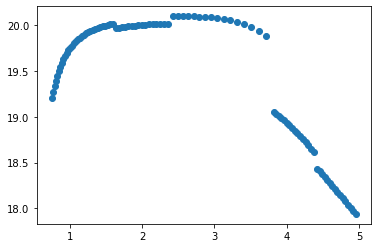

In [55]:
Tint
plt.scatter(wl, mag5)

# <span style='color:DarkSlateBlue'> Exercises </span>

In [62]:
I_FPA

3.4343692055707433e-10

## 3.1 Assume that SPHEREx is broken and can be cooled down only 200K instead of 50-80K. What would happen to the sensitivity?

## 3.2 (Advanced) Based on this notebook, re-produce the full prediction for SPHEREx All-sky and deep field sensitiviey plot.

## 3.3 (Advanced) Design a new space mission following mission goals
- **Goal**: We want to detect Ly$\alpha$ emission from first galaxies at z=10-20 (if exist) using similar LVF mapping technology. 
- Basic specification
    - wavelength range = 1 - 2$\mu$m
    - R = 100
    - survey area = 1000 deg$^2$
    - point-source sensitivity = 0.5e-17 erg/s/cm$^2$
    - pixel scale = 0.25 arcsec/pixel

## 3.4 (Advanced) Estimate sensitivity assuming that SPHEREx is a ground-based telescope.